In [1]:
import sys
import os
import numpy as np
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
# Add the project root directory to Python path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import matplotlib.pyplot as plt

from utils.plots import EDAPlots
from utils.eia_api import EIADataPuller
from utils.custom_types import StorageRegion, FuelType, EIAConsumptionType

# Program/Anaysis Constants

In [2]:
ANALYSIS_REGION = StorageRegion.EAST
data_puller = EIADataPuller(ANALYSIS_REGION)

# EIA Natural Gas Storage Numbers

In [3]:
df = data_puller.get_storage_data()
df['Year'] = df['period'].dt.year
df['DayOfYear'] = df['period'].dt.dayofyear

print(f"\nDtypes: {df.dtypes}")
df

{'response': {'total': '344', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'weekly', 'data': [{'period': '2019-01-18', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '566', 'units': 'BCF'}, {'period': '2019-02-08', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '444', 'units': 'BCF'}, {'period': '2019-05-03', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EP

,period,EAST_Region_NG_Storage_BCF,Year,DayOfYear
0,2025-08-01,656,2025,213
1,2025-07-25,651,2025,206
2,2025-07-18,634,2025,199
3,2025-07-11,628,2025,192
4,2025-07-04,616,2025,185
...,...,...,...,...
339,2019-02-01,468,2019,32
340,2019-01-25,527,2019,25
341,2019-01-18,566,2019,18
342,2019-01-11,620,2019,11


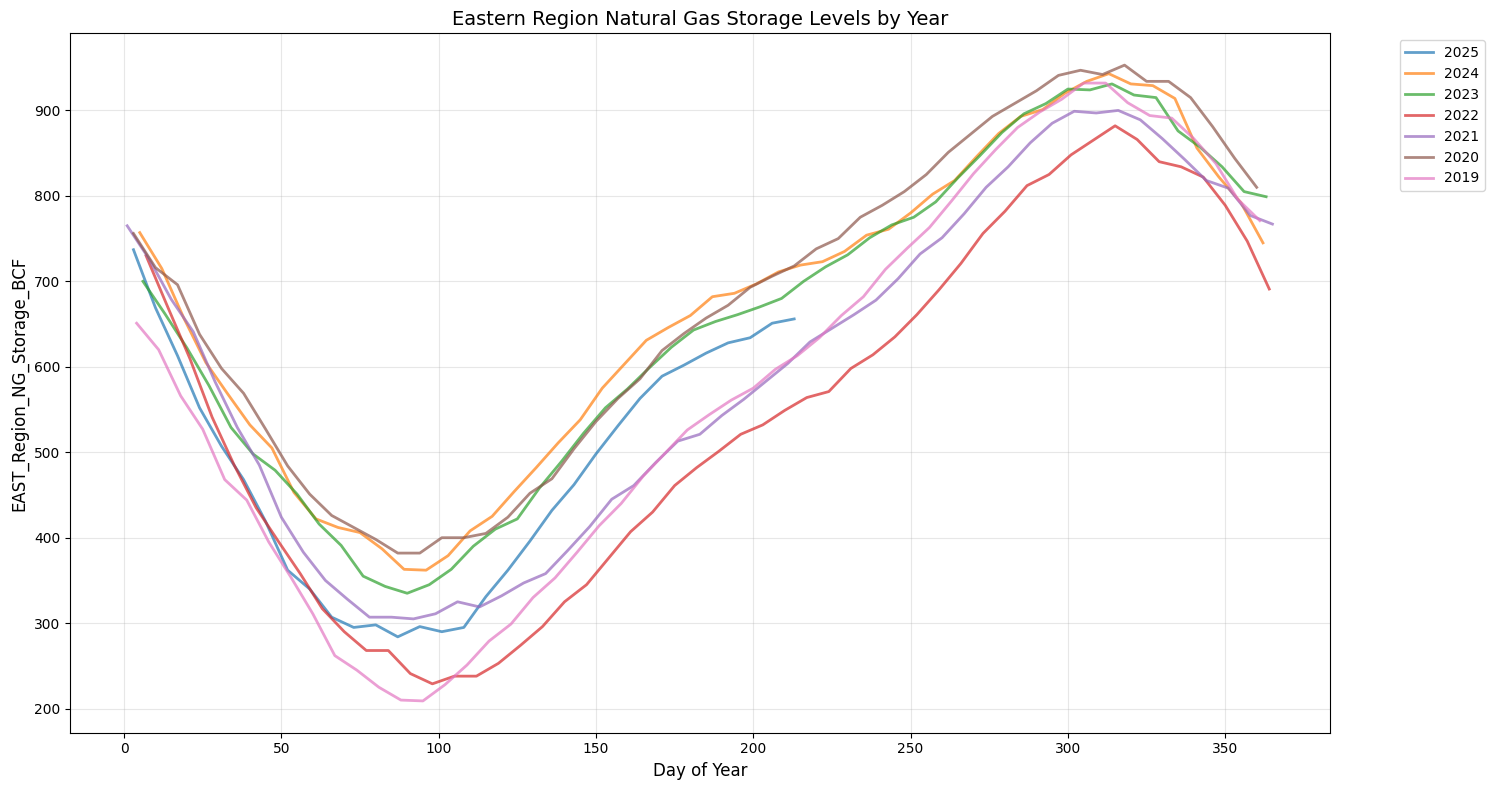

In [4]:
EDAPlots.generate_year_plot(df, 'EAST_Region_NG_Storage_BCF', 'Eastern Region Natural Gas Storage Levels by Year')

# Power Generation

In [5]:
power_gen_df = data_puller.get_power_gen_data(FuelType.NATURAL_GAS)

# power_gen_df['Year'] = power_gen_df['period'].dt.year
# power_gen_df['DayOfYear'] = power_gen_df['period'].dt.dayofyear

print(f"\nDtypes: {power_gen_df.dtypes}")
power_gen_df

{'warnings': [{'warning': 'incomplete return', 'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}], 'response': {'total': '9659', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'daily', 'data': [{'period': '2025-08-12', 'respondent': 'CAR', 'respondent-name': 'Carolinas', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '206002', 'value-units': 'megawatthours'}, {'period': '2025-08-12', 'respondent': 'MIDA', 'respondent-name': 'Mid-Atlantic', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '1408513', 'value-units': 'megawatthours'}, {'period': '2025-08-12', 'respondent': 'NE', 'respondent-name': 'New England', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '259675', 'value-units

,Week,Year,Region_NG_Power_Gen_MWh
0,0,2019,9.004496e+05
1,0,2020,1.050378e+06
2,0,2021,1.181554e+06
3,0,2022,9.600410e+05
4,0,2024,1.585946e+06
...,...,...,...
346,52,2021,1.201993e+06
347,52,2022,1.214021e+06
348,52,2023,1.318246e+06
349,52,2024,1.221313e+06


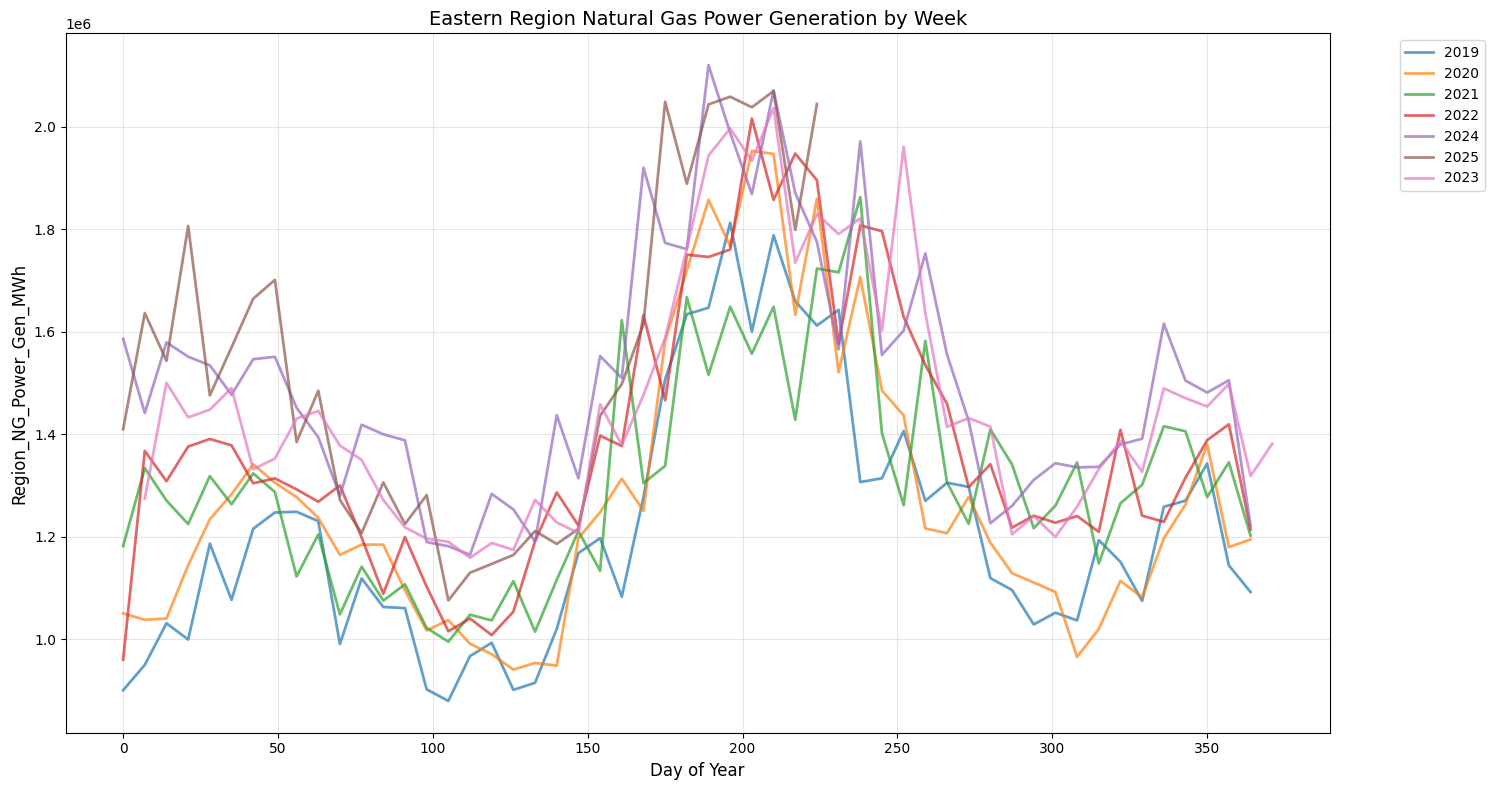

In [7]:
power_gen_df['DayOfYear'] = power_gen_df['Week'] * 7
EDAPlots.generate_year_plot(power_gen_df, "Region_NG_Power_Gen_MWh", "Eastern Region Natural Gas Power Generation by Week")

# NG Usage Data

In [8]:
usage_type = EIAConsumptionType.RESIDENTIAL
df = data_puller.get_ng_usage_data(usage_type)
df

{'response': {'total': '735', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2005-02', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VRS', 'process-name': 'Residential Consumption', 'series': 'N3010NE2', 'series-description': 'Nebraska Natural Gas Residential Consumption (MMcf)', 'value': '6736', 'units': 'MMCF'}, {'period': '2007-04', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VRS', 'process-name': 'Residential Consumption', 'series': 'N3010NE2', 'series-description': 'Nebraska Natural Gas Residential Consumption (MMcf)', 'value': '3221', 'units': 'MMCF'}, {'period': '2008-11', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VRS', 'process-name': 'Residential Consumption', 'series': 'N3010NE2', 'series-description': 'Nebraska Natural Gas Residential Consumption (MMcf)', 'value': '2626', 'units

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2005-02,SNE,USA-NE,EPG0,Natural Gas,VRS,Residential Consumption,N3010NE2,Nebraska Natural Gas Residential Consumption (...,6736,MMCF
1,2007-04,SNE,USA-NE,EPG0,Natural Gas,VRS,Residential Consumption,N3010NE2,Nebraska Natural Gas Residential Consumption (...,3221,MMCF
2,2008-11,SNE,USA-NE,EPG0,Natural Gas,VRS,Residential Consumption,N3010NE2,Nebraska Natural Gas Residential Consumption (...,2626,MMCF
3,2010-02,SNE,USA-NE,EPG0,Natural Gas,VRS,Residential Consumption,N3010NE2,Nebraska Natural Gas Residential Consumption (...,6848,MMCF
4,2010-06,SNE,USA-NE,EPG0,Natural Gas,VRS,Residential Consumption,N3010NE2,Nebraska Natural Gas Residential Consumption (...,1041,MMCF
...,...,...,...,...,...,...,...,...,...,...,...
730,2023-08,SFL,FLORIDA,EPG0,Natural Gas,VRS,Residential Consumption,N3010FL2,Florida Natural Gas Residential Consumption (M...,843,MMCF
731,2023-09,SFL,FLORIDA,EPG0,Natural Gas,VRS,Residential Consumption,N3010FL2,Florida Natural Gas Residential Consumption (M...,925,MMCF
732,2023-10,SFL,FLORIDA,EPG0,Natural Gas,VRS,Residential Consumption,N3010FL2,Florida Natural Gas Residential Consumption (M...,1172,MMCF
733,2024-12,SFL,FLORIDA,EPG0,Natural Gas,VRS,Residential Consumption,N3010FL2,Florida Natural Gas Residential Consumption (M...,2384,MMCF


In [9]:
EXP_COLS = ["period", "value"]
ls = (df[EXP_COLS]
    .fillna(0)
    .astype({"value": int, "period": "datetime64[ns]"})
    .groupby("period")["value"].sum()
    .reset_index(drop=False)
    .sort_values(by="period", ascending=True)
)
ls

,period,value
0,2005-01-01,76909
1,2005-02-01,77358
2,2005-03-01,72113
3,2005-04-01,46496
4,2005-05-01,29373
...,...,...
240,2025-01-01,97321
241,2025-02-01,82589
242,2025-03-01,57791
243,2025-04-01,34380


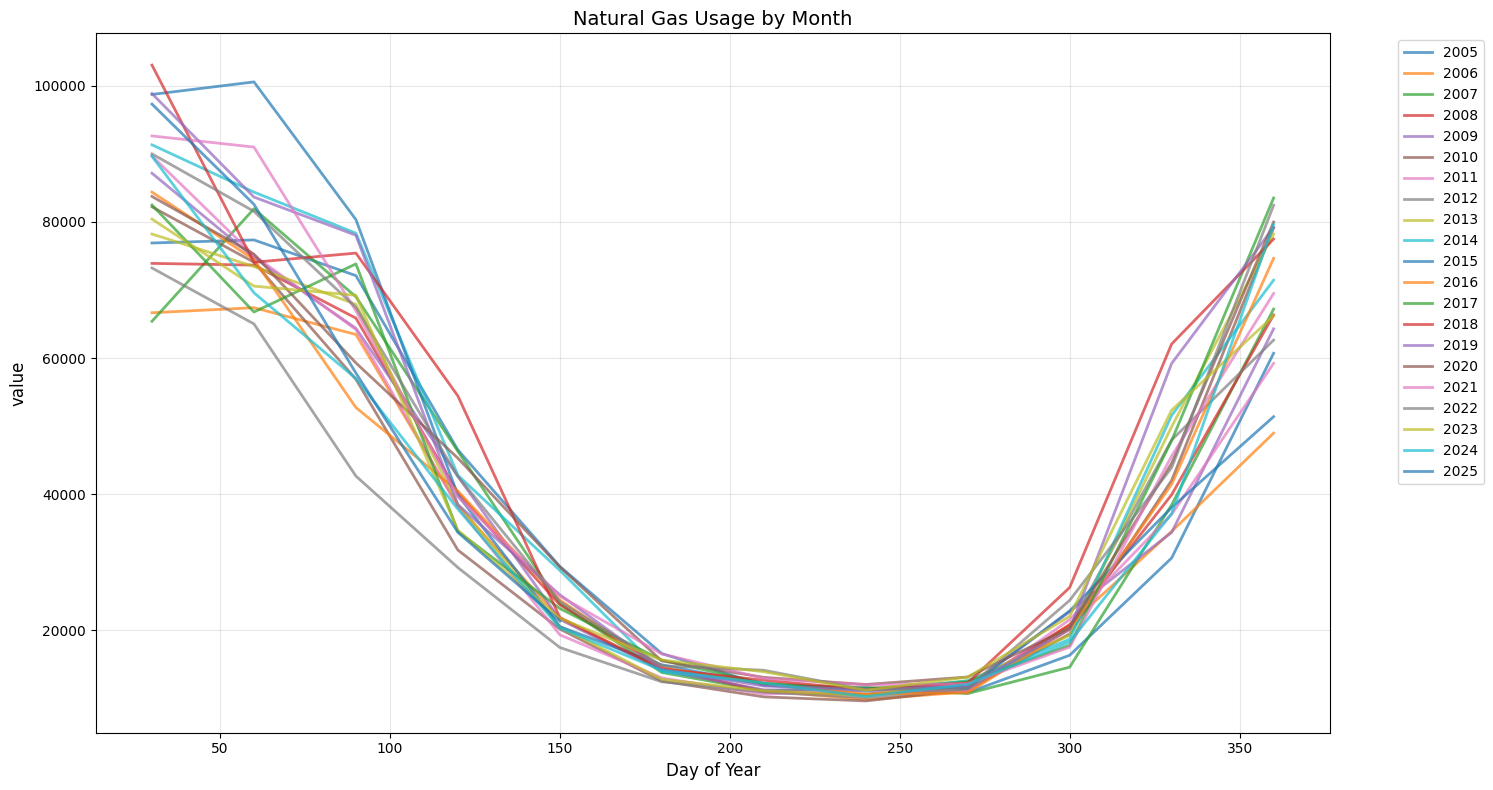

In [10]:
ls['Year'] = ls['period'].dt.year
ls["DayOfYear"] = ls['period'].dt.month * 30

EDAPlots.generate_year_plot(ls, "value", "Natural Gas Usage by Month")
# ls

In [11]:
ls['Week'] = ls['period'].dt.strftime("%U").astype(int)
ls['Year'] = ls['period'].dt.year
ls['Month'] = ls['period'].dt.month

weekly_index = pd.date_range(ls['period'].min(), ls['period'].max(), freq='W')
weekly_df = pd.DataFrame(weekly_index,columns=['period'])
weekly_df['Week'] = weekly_df['period'].dt.strftime("%U").astype(int)
weekly_df['Year'] = weekly_df['period'].dt.year
weekly_df['Month'] = weekly_df['period'].dt.month
weekly_df

merged_df = pd.merge(weekly_df, ls.drop(columns=['period', 'Month']), on=['Week', 'Year'], how='left')
merged_df['value'] = merged_df['value'].interpolate(method="linear", limit_direction="both")

monthly_totals = merged_df.groupby(['Year', 'Month'])['value'].sum().reset_index(drop=False)
scaling_factor = pd.merge(monthly_totals, ls, on=['Year', 'Month'], how='left').drop(columns=['period']).rename(columns={'value_x': 'monthly_sum', 'value_y': 'target_sum'})
scaling_factor['scaling_factor'] = scaling_factor['target_sum'] / scaling_factor['monthly_sum']
scaling_factor

merged_df_with_scaling = pd.merge(merged_df, scaling_factor.drop(columns=['monthly_sum', 'target_sum', 'Week']), on=['Year', 'Month'], how='left')
merged_df_with_scaling

,period,Week,Year,Month,value,DayOfYear_x,DayOfYear_y,scaling_factor
0,2005-01-02,1,2005,1,77358.00,NaN,30,0.198839
1,2005-01-09,2,2005,1,77358.00,NaN,30,0.198839
2,2005-01-16,3,2005,1,77358.00,NaN,30,0.198839
3,2005-01-23,4,2005,1,77358.00,NaN,30,0.198839
4,2005-01-30,5,2005,1,77358.00,60.0,30,0.198839
...,...,...,...,...,...,...,...,...
1056,2025-03-30,13,2025,3,34380.00,120.0,90,0.264221
1057,2025-04-06,14,2025,4,31121.25,NaN,120,0.327639
1058,2025-04-13,15,2025,4,27862.50,NaN,120,0.327639
1059,2025-04-20,16,2025,4,24603.75,NaN,120,0.327639


In [12]:
merged_df_with_scaling['value'] = merged_df_with_scaling['value'] * merged_df_with_scaling["scaling_factor"]
merged_df_with_scaling

,period,Week,Year,Month,value,DayOfYear_x,DayOfYear_y,scaling_factor
0,2005-01-02,1,2005,1,15381.800000,NaN,30,0.198839
1,2005-01-09,2,2005,1,15381.800000,NaN,30,0.198839
2,2005-01-16,3,2005,1,15381.800000,NaN,30,0.198839
3,2005-01-23,4,2005,1,15381.800000,NaN,30,0.198839
4,2005-01-30,5,2005,1,15381.800000,60.0,30,0.198839
...,...,...,...,...,...,...,...,...
1056,2025-03-30,13,2025,3,9083.926537,120.0,90,0.264221
1057,2025-04-06,14,2025,4,10196.541348,NaN,120,0.327639
1058,2025-04-13,15,2025,4,9128.847116,NaN,120,0.327639
1059,2025-04-20,16,2025,4,8061.152884,NaN,120,0.327639


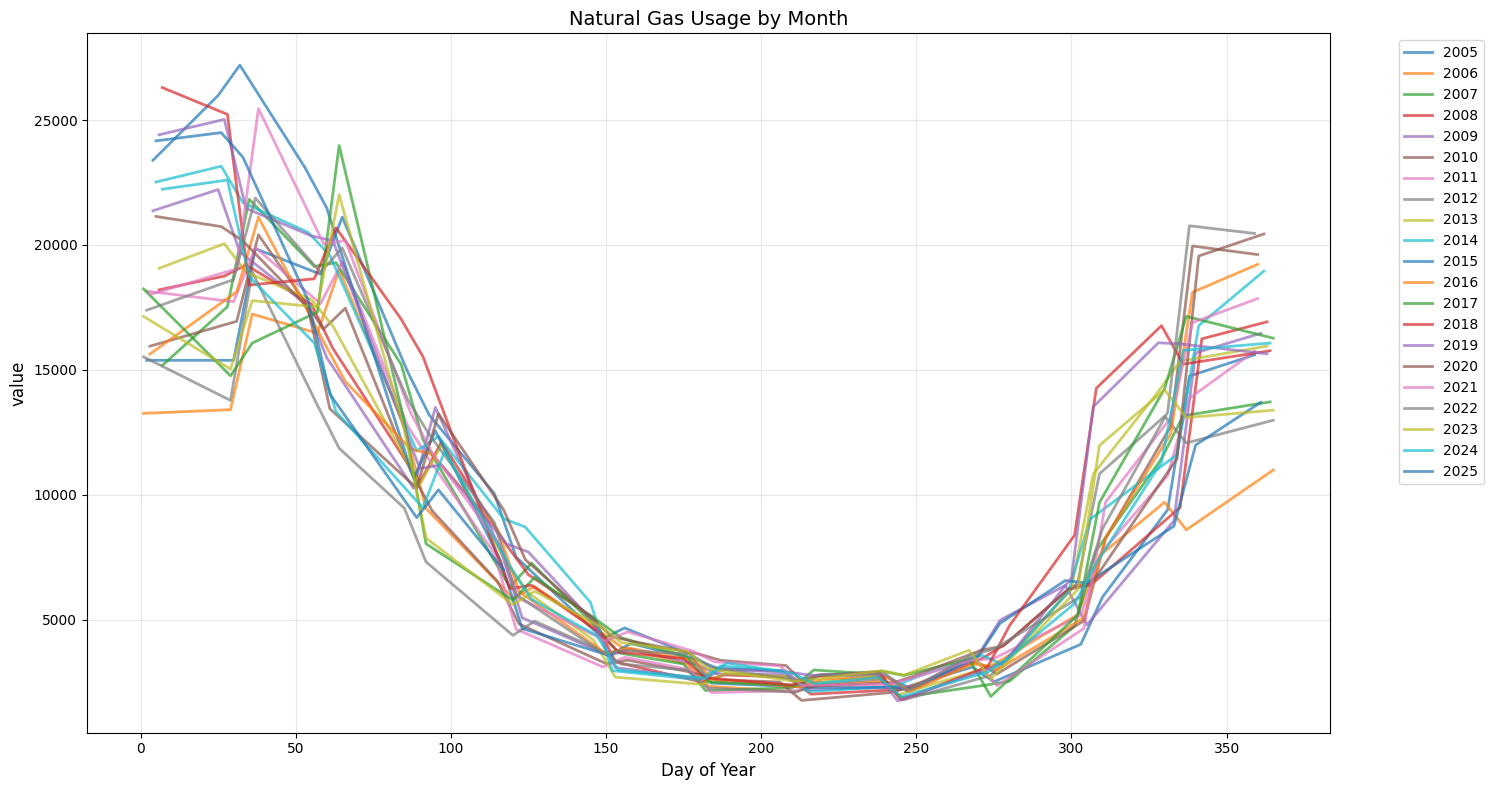

In [13]:
merged_df_with_scaling['DayOfYear'] = merged_df_with_scaling['period'].dt.dayofyear
EDAPlots.generate_year_plot(merged_df_with_scaling, "value", "Natural Gas Usage by Month")

In [14]:
scaling_factor

,Year,Month,monthly_sum,target_sum,DayOfYear,Week,scaling_factor
0,2005,1,386790.0,76909,30,0,0.198839
1,2005,2,296319.5,77358,60,5,0.261063
2,2005,3,224409.5,72113,90,9,0.321346
3,2005,4,151738.0,46496,120,13,0.306423
4,2005,5,114857.5,29373,150,18,0.255734
...,...,...,...,...,...,...,...
239,2024,12,401852.5,79631,360,48,0.198160
240,2025,1,328137.5,97321,30,0,0.296586
241,2025,2,268361.0,82589,60,4,0.307753
242,2025,3,218722.0,57791,90,8,0.264221
